In [45]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

In [46]:
data = pd.read_parquet('./input/creditos_hist.parquet')

In [47]:
# Eliminamos las situaciones 0, que indican que el crédito ya fue pagado
data = data.loc[data['situacion'] != 0]
data = data.drop('denominacion', axis = 1) # Elimino la columna con las razones sociales para ahorrar RAM

In [48]:
# Elijo aleatoriamente un porcentaje de las empresas de la población
np.random.seed(42)
cuits = data['identificacion'].unique()
moneda = np.random.binomial(1, 0.002, len(cuits)) # Es como tirar una moneda sesgada para que agarre un porcentaje arbitrario de las empresas 
cuits_aleatorios = cuits[moneda == 1] # Estos son los cuits con los que me voy a quedar
data = data.loc[data['identificacion'].isin(cuits_aleatorios)] # Me quedo unicamente con las obs que tienen un cuit dentro de los seleccionados aleatoriamente

In [49]:
pv = pd.read_parquet('./input/principales_variables.parquet') # Datos de principales variables monetarias provenientes de la API del BCRA
pv.reset_index(inplace= True) # el index es la fecha, así que lo paso a columna
pv['fecha'] = pd.to_datetime(pv['fecha']) # paso la nueva columna al formato correcto
pv['periodo'] = pv['fecha'].dt.strftime('%Y%m') # armo una variable llamada periodo igual a la que tengo en los datos de la Central de Deudores
pv = pv.drop('fecha', axis = 1).groupby('periodo').agg(['mean', 'std']) # elimino la de "fecha" porque no me interesan los datos diarios
# Me quedo únicamente con los promedios por mes y también calculo el desvío estándar
pv.columns = ['_'.join(col).strip() for col in pv.columns] # Renombro las columnas para que sea más prolijo
pv.reset_index(inplace= True) # Vuelvo a agregar la columna periodo
pv = pv.loc[pv['periodo'].astype(int) <= 202411] # En la Central de Deudores tenemos datos hasta 202410
pv = pv.dropna(axis = 1) # Elimino las columnas con NAs

In [50]:
data = data.merge(pv, on = 'periodo', how = 'left') # Junto las principales variables monetarias con la Central de Deudores

In [51]:
emae = pd.read_excel('./input/sh_emae_mensual_base2004.xls', index_col=[0,1])
meses_a_numeros = {
    'Enero': '01', 'Febrero': '02', 'Marzo': '03', 'Abril': '04',
    'Mayo': '05', 'Junio': '06', 'Julio': '07', 'Agosto': '08',
    'Septiembre': '09', 'Octubre': '10', 'Noviembre': '11', 'Diciembre': '12'
}
emae = emae.reset_index()
emae['level_1'] = emae['level_1'].map(meses_a_numeros)
emae['periodo'] = emae['Período'].astype(str) + emae['level_1']
emae = emae.drop(columns=['level_1', 'Período'])

In [52]:
data = data.merge(emae, on = 'periodo', how= 'left')

In [53]:
arca = pd.read_parquet('./input/constancia_inscripcion.parquet') # Cargo los datos de la constancia de inscripción de ARCA
arca = arca.drop(['direccion', 'localidad', 'razonSocial'], axis = 1) # Elimino algunas variables para ahorrar RAM

In [54]:
data = data.merge(arca, on = 'identificacion', how= 'left') # Junto las bases

# Variables de interés
Creamos nuevas variables que creemos que pueden ser útiles para predecir el default

In [55]:
# Una variable que puede ser de interés es cuantos créditos tiene una empresa en un momento dado del tiempo
counts = data.groupby(['identificacion', 'periodo']).size().reset_index(name='n_creditos')

# También nos interesa cuanta plata debe una empresa en cada momento dado
sums = data.groupby(['identificacion', 'periodo'], as_index=True)['monto'].sum().reset_index(name='sum_montos')

# La literatura indica que también importa la duración de la relación empresa-banco, por lo que contamos la cantidad 
# de periodos que aparece cada par: empresa-banco
period_counts = data.groupby(['identificacion', 'entidad']).size().reset_index(name='n_periodos')

# Definimos como default cuando el crédito se encuentra en situación 4 o 5, por lo que creamos la dummy de default
# Esta es nuestra variable dependiente
data['default'] = (data['situacion'] > 4).astype(int)

In [56]:
data = data.sort_values(by=['identificacion', 'periodo'])
data['prev_default'] = (
    data.groupby('identificacion')['default']
    .transform(lambda x: x.cumsum().clip(upper=1))
) # Armamos una variable que indique si en algún momento de su historia, esa empresa tuvo un crédito en default

In [57]:
# Queremos predecir el default el periodo siguienre
data['default_lag'] = data.groupby('identificacion')['default'].shift(1) # Lag a la variable default
data = data.dropna(subset=['default_lag']) # Eliminamos las observaciones que no tienen variable dependiente
data['default_lag'] = data['default_lag'].astype(int) # Cambio el dtype de la variable de interés

In [58]:
# Agregamos las nuevas variables al dataframe
data = data.merge(counts, on=['identificacion', 'periodo'], how='left')
data = data.merge(sums, on=['identificacion', 'periodo'], how='left')
data = data.merge(period_counts, on=['identificacion', 'entidad'], how='left')

del sums, counts, period_counts # Para ahorrar RAM

In [59]:
# Por último, la literatura también resalta que la intensidad de la relación empresa-banco es relevante
# Usamos como proxy para la intensidad la proporción del monto adeudado con un banco sobre el total adeudado
data['monto_relativo'] = data['monto'] / data['sum_montos']

In [60]:
# Ponemos bien el tipo de dato para las columnas categóricas, así el get_dummies funciona bien
data['identificacion'] = data['identificacion'].astype('category')
data['entidad'] = data['entidad'].astype('category')
data['situacion'] = data['situacion'].astype('category')
data['default'] = data['default'].astype('category')
data['periodo'] = data['periodo'].astype('category')
data['codPostal'] = data['codPostal'].astype('category')
data['mesCierre'] = data['mesCierre'].astype('category')
data['provincia'] = data['provincia'].astype('category')
data['default_lag'] = data['default_lag'].astype('category')
data['prev_default'] = data['prev_default'].astype('category')

In [61]:
Y = data.loc[data['IVA'].notna()]['default_lag'] # Nuestra variable de interés para las empresas para las cuales tenemos datos de ARCA
Y_sin_arca = data.loc[~data['IVA'].notna()]['default_lag'] # Para estas no tenemos datos de ARCA

Para hacer cross validation, tenemos que tener en cuenta que tenemos un panel. Por lo tanto, vamos a entrenar el modelo con datos del pasado y evaluarlo con datos del futuro

In [62]:
# Cross Validation
data = data.sort_values(by='periodo') # Ordeno de acuerdo a la fecha
split_index = int(len(data) * 0.8) # El 80% de las observaciones más antiguas
train_indices = data.iloc[:split_index].index # Estos son los índices con los que después voy a separar en test y train
test_indices = data.iloc[split_index:].index

In [63]:
boolean_columns = data.select_dtypes(include='object').columns # Estas son las columnas que ya están en el formato correcto
columnas = ['entidad', 'monto', 'n_creditos', 'sum_montos', 'n_periodos', 'monto_relativo', 'prev_default'] # Algunas de las variables independientes del modelo
columnas.extend(arca.columns) # Todas las columnas de ARCA
pv.set_index('periodo', inplace= True)
columnas.extend(pv.columns) # Todas las columnas de las principales variables monetarias
columnas.extend(emae.columns) # Todas las columnas de emae
columnas.pop(8) # No voy a agregar efectos fijos, así que lo saco

'identificacion'

In [64]:
columns_to_encode = [col for col in columnas if col not in boolean_columns] # Una lista con las columnas que no tengo que meter en "get_dummies"
X_encoded = pd.get_dummies(data[columns_to_encode], drop_first=True) # Meto las columnas en get_dummies
data = pd.concat([X_encoded, data[boolean_columns]], axis=1) # Junto todas las variables independientes en un solo df

del columns_to_encode, X_encoded

In [65]:
sin_arca = data[~data['IVA'].notna()] # Estas son las X para las que no tenemos datos de ARCA
X = data[data['IVA'].notna()] # Las X para las que si tenemos datos de ARCA

In [66]:
# Intersección entre conjunto de entrenamiento y tienen datos para ARCA
train_indices = [idx for idx in train_indices if idx in X.index]
test_indices = [idx for idx in test_indices if idx in X.index]

In [67]:
# Separo en entrenamiento y test
X_train = X.loc[train_indices]
Y_train = Y.loc[train_indices]
X_test = X.loc[test_indices]
Y_test = Y.loc[test_indices]

También se puede hacer con neg_mean_squared_error, accuracy, f1_macro, f1_samples, average_precision, etc

In [68]:
tscv = TimeSeriesSplit(n_splits=10) # Este cross validation tiene en cuenta la temporarlidad de la base

pipeline = Pipeline([
    ('scaler', StandardScaler()), # Primero estandariza los datos
    ('logreg', LogisticRegressionCV( # Estima el modelo usando cross validation para elegir el mejor hiperparámetro
        cv=tscv,
        penalty='l1',
        solver='saga',
        scoring='accuracy',
        max_iter=2000,
        random_state= 42,
        tol = 1e-3,
        n_jobs= -1,
        fit_intercept= True
    ))
])

In [69]:
pipeline.fit(X_train, Y_train) # Entreno el modelo

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegressionCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                                      max_iter=2000, n_jobs=-1, penalty='l1',
                                      random_state=42, scoring='accuracy',
                                      solver='saga', tol=0.001))])

In [77]:
import joblib
joblib.dump(pipeline, './output/logreg_pipeline.pkl')

['./output/logreg_pipeline.pkl']

In [70]:
y_pred = pipeline.predict(X_test) # Hago las predicciones
cm = confusion_matrix(Y_test, y_pred) # Veo que tan bien funciona
print(cm)

[[3137    4]
 [   0   11]]


In [71]:
# Métricas
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)

print(f'La precisión es: {precision}')
print(f'El recall es: {recall}')
print(f'El f1 es: {f1}')
print(f'El accuracy es: {accuracy}')

La precisión es: 0.7333333333333333
El recall es: 1.0
El f1 es: 0.8461538461538461
El accuracy es: 0.998730964467005


Si predecimos siempre negativo:
|       | PN    | PP    |
|-------|-------|-------|
| **TN** | 1360 | 0     |
| **TP** | 12  | 0     |

* La precision sería: 0/0
* El recall sería: 0
* El f1 sería: 0
* El accuracy sería: 0.9912536443

In [72]:
model = pipeline.named_steps['logreg'] # Agarro el modelo desde el pipeline

In [73]:
best_c = model.C_
print(f'El mejor lambda para el modelo es: {best_c}')

El mejor lambda para el modelo es: [0.04641589]


In [74]:
df_coeficientes = pd.DataFrame({
    'variable': X_train.columns,
    'coeficiente': model.coef_[0]
})
print(df_coeficientes)

                                               variable  coeficiente
0                                                 monto          0.0
1                                            n_creditos          0.0
2                                            sum_montos          0.0
3                                            n_periodos          0.0
4                                        monto_relativo          0.0
...                                                 ...          ...
1918    VENTA DE AUTOS, CAMIONETAS Y UTILITARIOS NUEVOS          0.0
1919   VENTA DE AUTOS, CAMIONETAS Y UTILITARIOS, USADOS          0.0
1920  VENTA DE MOTOCICLETAS Y DE SUS PARTES, PIEZAS ...          0.0
1921       VENTA DE VEHÍCULOS AUTOMOTORES NUEVOS N.C.P.          0.0
1922       VENTA DE VEHÍCULOS AUTOMOTORES USADOS N.C.P.          0.0

[1923 rows x 2 columns]


In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

scores_df = pd.DataFrame(model.scores_[1], columns=[f'C={c:.2e}' for c in model.Cs_])
scores_df = scores_df.melt(var_name='C', value_name='Score')

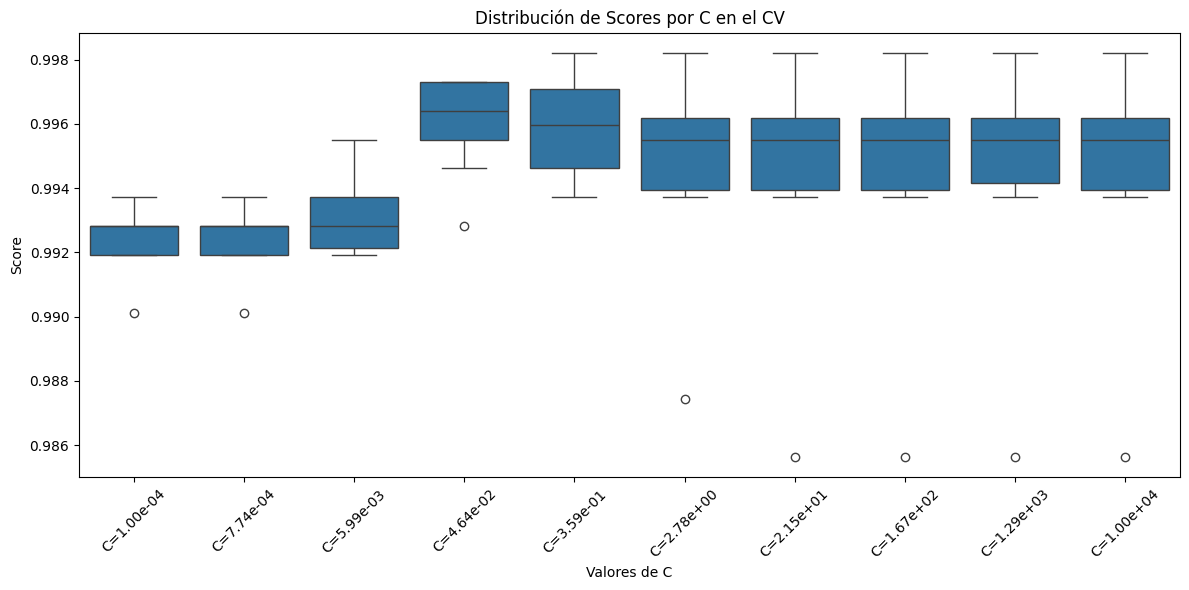

In [76]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=scores_df, x='C', y='Score')
plt.xticks(rotation=45) 
plt.title('Distribución de Scores por C en el CV')
plt.xlabel('Valores de C')
plt.ylabel('Score')
plt.tight_layout()
plt.show()